# Energy Efficiency Prediction

This notebook trains regression models to predict the heating load of buildings from the [UCI Energy Efficiency dataset](https://archive.ics.uci.edu/dataset/242/energy+efficiency).

In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Style setup
plt.style.use('seaborn-v0_8')
sns.set_context('talk')

In [36]:
# Load and inspect data

FILE_NAME = "ENB2012_data.xlsx"

COLUMN_MAP = {
    'X1': 'relative_compactness',
    'X2': 'surface_area',
    'X3': 'wall_area',
    'X4': 'roof_area',
    'X5': 'overall_height',
    'X6': 'orientation',
    'X7': 'glazing_area',
    'X8': 'glazing_area_distribution',
    'Y1': 'heating_load',
    'Y2': 'cooling_load'
}

data = pd.read_excel(FILE_NAME).rename(columns=COLUMN_MAP)

print(f"Data loaded successfully: {data.shape[0]} samples, {data.shape[1]} features")
display(data.head())

# Summary stats
display(data.describe().T)

Data loaded successfully: 768 samples, 10 features


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


,count,mean,std,min,25%,50%,75%,max
relative_compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
surface_area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
wall_area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
roof_area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
overall_height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
glazing_area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
glazing_area_distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
heating_load,768.0,22.307195,10.090204,6.01,12.9925,18.95,31.6675,43.10
cooling_load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


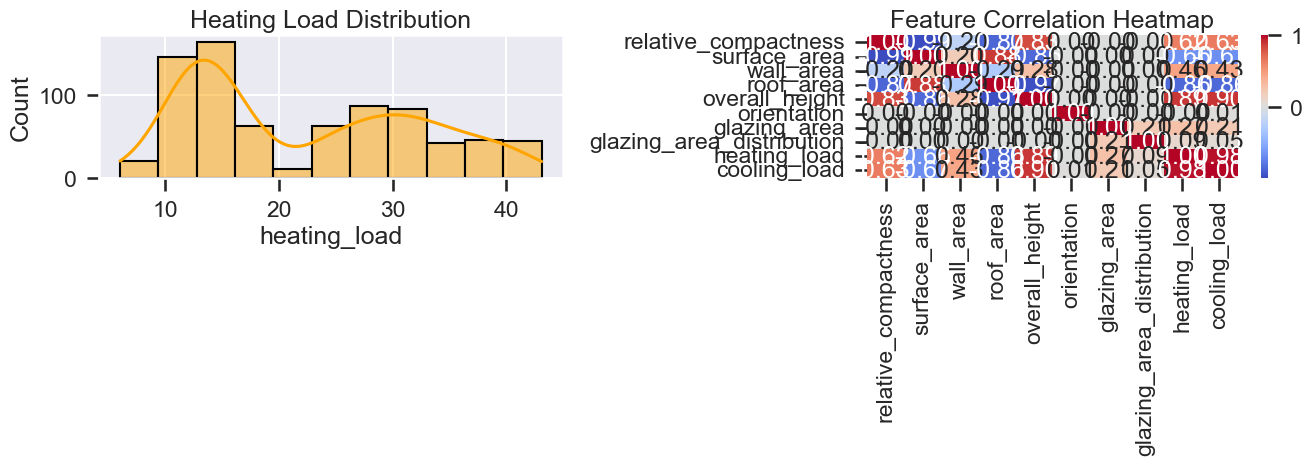

In [37]:
# Data Visualization & Correlation

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data['heating_load'], kde=True, ax=axes[0], color="orange")
axes[0].set_title("Heating Load Distribution")

corr = data.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Feature Correlation Heatmap")

plt.tight_layout()
plt.show()


In [38]:
# Split features and targets
X = data[['relative_compactness', 'surface_area', 'wall_area',
          'roof_area', 'overall_height', 'orientation',
          'glazing_area', 'glazing_area_distribution']]

y = data[['heating_load', 'cooling_load']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [39]:
# Preprocessing
num_features = ['relative_compactness', 'surface_area', 'wall_area',
                'roof_area', 'overall_height', 'glazing_area']
cat_features = ['orientation', 'glazing_area_distribution']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])


In [40]:
# Optimized XGBoost Model
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    reg_lambda=1.0,
    random_state=42
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", MultiOutputRegressor(xgb))
])

model.fit(X_train, y_train)
print("XGBoost model trained successfully!")


XGBoost model trained successfully!


In [41]:
# Evaluate performance
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation Results:")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

Model Evaluation Results:
MAE  : 0.527
MSE  : 0.941
RMSE : 0.970
R²   : 0.990


In [ ]:
param_grid = {
    "regressor__estimator__n_estimators": [300, 400, 600],
    "regressor__estimator__max_depth": [4, 6, 8],
    "regressor__estimator__learning_rate": [0.03, 0.05, 0.1],
    "regressor__estimator__subsample": [0.8, 0.9, 1.0],
    "regressor__estimator__colsample_bytree": [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


In [ ]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

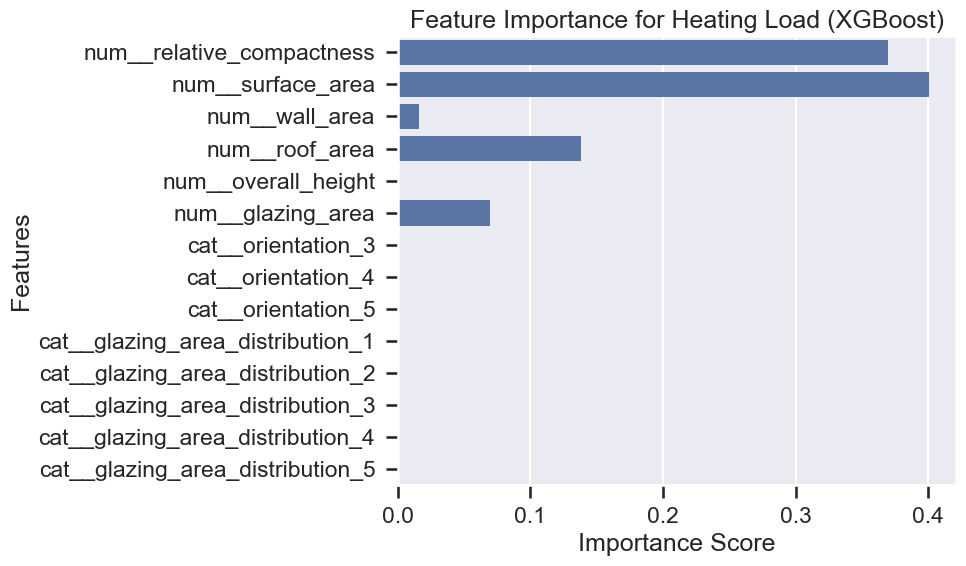

In [30]:
# Feature Importance (using one target for simplicity)
final_xgb = model.named_steps['regressor'].estimators_[0]  # first target
feature_names = preprocessor.get_feature_names_out()
importances = final_xgb.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance for Heating Load (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


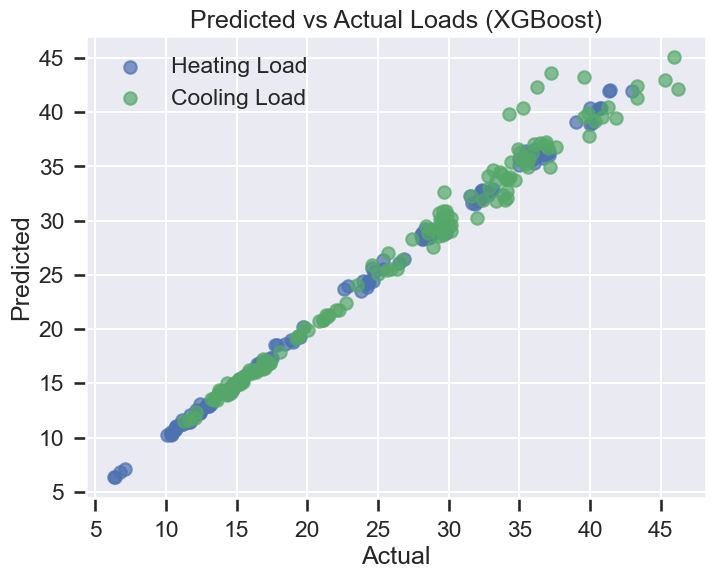

In [31]:
# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test['heating_load'], y_pred[:, 0], alpha=0.7, label="Heating Load")
plt.scatter(y_test['cooling_load'], y_pred[:, 1], alpha=0.7, label="Cooling Load")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Loads (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()
